# Projection on learning dimension and decoding

Implement PCA or other dimensionality reduction techniques.
Project activity on "learning" dimension defined as difference between meaningful average population response.

In [63]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import umap
from matplotlib.backends.backend_pdf import PdfPages
from nwb_wrappers import nwb_reader_functions as nwb_read
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import src.utils.utils_imaging as imaging_utils
import src.utils.utils_io as io
from src.behavior import compute_performance, plot_single_session

# Set plot parameters.
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

# Path to the directory containing the processed data.
processed_dir = r"//sv-nas1.rcp.epfl.ch/Petersen-Lab/analysis/Anthony_Renard/data_processed/mice"
nwb_dir = r"//sv-nas1.rcp.epfl.ch/Petersen-Lab/analysis/Anthony_Renard/NWB"

# Session metadata file.
db_path = r"//sv-nas1.rcp.epfl.ch/Petersen-Lab/analysis/Anthony_Renard/mice_info/session_metadata.xlsx"

# Rewarded and non-rewarded NWB files.
group_yaml_rew = r"//sv-nas1.rcp.epfl.ch/Petersen-Lab/analysis/Anthony_Renard/mice_info/groups/imaging_rewarded.yaml"
group_yaml_non_rew = r"//sv-nas1.rcp.epfl.ch/Petersen-Lab/analysis/Anthony_Renard/mice_info/groups/imaging_non_rewarded.yaml"
nwb_list_rew = io.read_group_yaml(group_yaml_rew)
nwb_list_non_rew = io.read_group_yaml(group_yaml_non_rew)
nwb_list = nwb_list_rew + nwb_list_non_rew


def shape_feature_matrix(activity, win, fitting_type='single_bin', zscore=True):
    
    if fitting_type == 'single_bin':
        X = np.mean(activity[:, :, :, win[0]:win[1]], axis=3)
        X = np.reshape(X, (X.shape[0], -1))
    elif fitting_type == 'psth':
        X = np.mean(activity, axis=2)
    else:
        raise ValueError('Unknown fitting type.')
    
    # Transpose to (n_samples, n_features).
    X = X.T
    # z-score the data.
    if zscore:
        X = StandardScaler(with_mean=True, with_std=True).fit_transform(X)
    
    return X


def apply_pca_model(activity, model, n_days, n_trials):
    # Apply the model.
    # Reshape activity to (n_neurons, n_trials x n_timepoints) and transform.
    reduced_act = model.transform(activity.reshape(activity.shape[0], -1).T)
    reduced_act = reduced_act.T
    n_pc = model.n_components_
    s = activity.shape
    # First dim length is min(n_features, n_samples).
    # Add session dimension.
    reduced_act = reduced_act.reshape(n_pc, n_days, n_trials, s[-1])
    
    return reduced_act


def pc_to_retain(model, threshold):
    
    mask = model.explained_variance_ratio_.cumsum() < threshold
    # Also select the first PC that crosses the threshold.
    pc_that_cross = (mask == False).argmax()
    mask[pc_that_cross] = True
    
    return mask

## Part 1. PCA and PC PSTH's

PCA in performed on the mapping trials.

In [9]:
sampling_rate = 30
trial_type = 'UM'
n_trials = 50
n_days = 5
win = (1, 2)  # from stimulus onset to 300 ms after.
win = (int(win[0] * sampling_rate), int(win[1] * sampling_rate))
baseline = (0, 1)
baseline = (int(baseline[0] * sampling_rate), int(baseline[1] * sampling_rate))

mouse_list = ['AR127']

session_list = io.select_sessions_from_db(db_path,
                                          experimenters=['AR', 'GF', 'MI'],
                                          exclude_cols=['exclude', 'two_p_exclude'],
                                          subject_id=mouse_list,
                                          reward_group='R+',
                                          day=['-2', '-1', '0', '+1', '+2'],
                                          two_p_imaging='yes')

activity = imaging_utils.shape_features_matrix(mouse_list, session_list, processed_dir, trial_type, 50)
# Subtract baselines.
activity = activity - np.nanmean(activity[:, :, baseline[0]:baseline[1]],
                                 axis=2, keepdims=True)

c:\Users\aprenard\Anaconda3\envs\fast-learning\Lib\site-packages\openpyxl\worksheet\_read_only.py:81: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():


### Shape feature matrix.
Fit PCA by either:
- for each neuron, keep all trial and compute the mean response over time.
- for each neuron, average trials and keep the mean response over time
(keep time dimension).


In [10]:

# X = np.mean(activity[:, :, :, win[0]:win[1]], axis=3)
X = np.mean(activity, axis=2)
X = np.reshape(X, (X.shape[0], -1))

# Transpose to (n_samples, n_features).
X = X.T
# z-score the data.
X = StandardScaler(with_mean=True, with_std=True).fit_transform(X)
# Perform PCA.
pca = PCA(n_components=None)
model = pca.fit(X)

### PC PSTH's
Look at the PC's average responses across days.

In [ ]:
# Apply the model.
# Reshape activity to (n_neurons, n_trials x n_timepoints) and transform.
reduced_act = model.transform(activity.reshape(activity.shape[0], -1).T)
reduced_act = reduced_act.T
n_pc = model.n_components_
s = activity.shape
# First dim length is min(n_features, n_samples).
# Add session dimension.
reduced_act = reduced_act.reshape(n_pc, n_days, n_trials, s[2])

# Create PC PSTH's. 
pc_psth = reduced_act - np.mean(reduced_act[:, :, :, baseline[0]:baseline[1]],
                                axis=3, keepdims=True)
pc_psth = np.mean(reduced_act, axis=2)

# Save PC PSTH to pdf.
pdf_path = r"\\sv-nas1.rcp.epfl.ch\Petersen-Lab\analysis\Anthony_Renard\analysis_output\pca\pca_exploration.pdf"
with PdfPages(pdf_path) as pdf:
    for pc in range(30):
        f, axes = plt.subplots(1, 5, sharey=True, figsize=(15, 5))
        for i in range(n_days):
            axes[i].plot(pc_psth[pc, i, :])
            axes[i].axvline(30, color='orange')
        f.suptitle(f"PC {pc+1}")
        pdf.savefig(f)
        plt.close()

### Look at loadings and explained variance


In [11]:
plt.figure()
plt.plot(model.explained_variance_ratio_.cumsum())

# Plot loading of first 10 PCs.
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.plot(model.components_[i])
    plt.title(f"PC {i+1}")
plt.tight_layout()
plt.show()

False


## Part 2. Similarity of population vectors across learning and projection on learning dimension.

### 1. Similarity measure between single trial responses and average expert population reponse.

Do we see a discret transition from before to after learning? or is it continuously drifting?
Is there even a noticable change before and after learning?

**Results**

Interesting dynamics. Orthogonalisation is observable. Some mice have discret transition. Some are more gradual.
Variance of distance seems to decrease over time.


c:\Users\aprenard\Anaconda3\envs\fast-learning\Lib\site-packages\openpyxl\worksheet\_read_only.py:81: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():


Trial type 'WH' is not present in the metadata.
Trial type 'WH' is not present in the metadata.
(180, 3, 50, 181)
(180, 5, 50, 181)
(180,)
(180, 5, 50)
(180, 3, 50)


c:\Users\aprenard\Anaconda3\envs\fast-learning\Lib\site-packages\pynwb\base.py:193: UserWarning: RoiResponseSeries 'F0': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
c:\Users\aprenard\Anaconda3\envs\fast-learning\Lib\site-packages\pynwb\base.py:193: UserWarning: RoiResponseSeries 'F_cor': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
c:\Users\aprenard\Anaconda3\envs\fast-learning\Lib\site-packages\pynwb\base.py:193: UserWarning: RoiResponseSeries 'F_raw': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data m

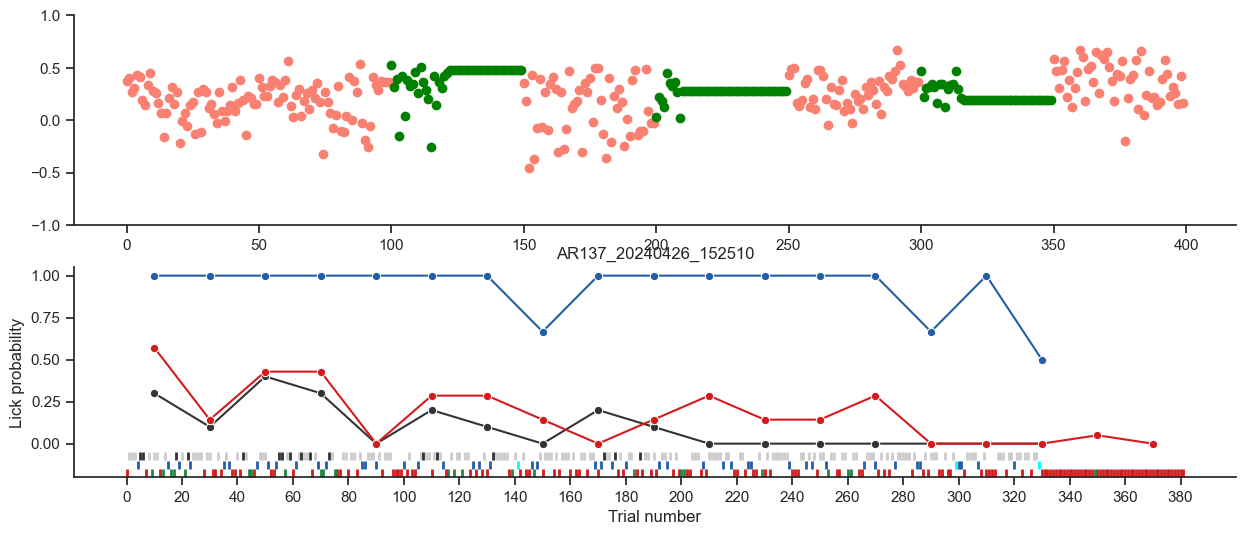

In [64]:
# Load data needed to compute before and after learning.

sampling_rate = 30
win = (1, 1.5)  # from stimulus onset to 300 ms after.
win = (int(win[0] * sampling_rate), int(win[1] * sampling_rate))
baseline = (0, 1)
baseline = (int(baseline[0] * sampling_rate), int(baseline[1] * sampling_rate))
n_trials = 50
days = ['-2', '-1', '0', '+1', '+2']
apply_pca = False
variance_to_retain = 0.8

mouse_list = ['AR137']

session_list, nwb_files = io.select_sessions_from_db(
    db_path, nwb_dir,
    experimenters=['AR', 'GF', 'MI'],
    exclude_cols=['exclude', 'two_p_exclude'],
    subject_id=mouse_list,
    day=['-2', '-1', '0', '+1', '+2'],
    two_p_imaging='yes')

act_map = imaging_utils.shape_features_matrix(mouse_list, session_list, processed_dir, 'UM', n_trials)
# Subtract baselines.
act_map = act_map - np.nanmean(act_map[:, :, baseline[0]:baseline[1]],
                               axis=2, keepdims=True)
act_learning = imaging_utils.shape_features_matrix(mouse_list, session_list, processed_dir, 'WH', n_trials)
# Subtract baselines.
act_learning = act_learning - np.nanmean(act_learning[:, :, baseline[0]:baseline[1]],
                               axis=2, keepdims=True)

# Add session dimension.
act_map = act_map.reshape(act_map.shape[0], int(act_map.shape[1]/n_trials), n_trials, -1)
act_learning = act_learning.reshape(act_learning.shape[0], int(act_learning.shape[1]/n_trials), n_trials, -1)


# TODO: dim reduction must be applied to all data Um and WH at the same time.
    
# Reduce dimensionality of the data.
if apply_pca:
    X = shape_feature_matrix(np.concatenate((act_learning, act_map), axis=1), win, fitting_type='single_bin')
    # Perform PCA.
    pca = PCA(n_components=None)
    model = pca.fit(X)
    act_map = apply_pca_model(act_map, model, 5, n_trials)
    act_map = act_map[pc_to_retain(model, variance_to_retain)]
    act_learning = apply_pca_model(act_learning, model, act_learning.shape[1], n_trials)
    act_learning = act_learning[pc_to_retain(model, variance_to_retain)]
print(act_learning.shape)
print(act_map.shape)

# Compute similarity between single trial population response and response after learning.
vect_after_learning = np.mean(act_map[:, 4, :, win[0]:win[1]], axis=(1,2))
print(vect_after_learning.shape)
pop_vect_mapping = np.mean(act_map[:, :, :, win[0]:win[1]], axis=(3))
pop_vect_learning = np.mean(act_learning[:, :, :, win[0]:win[1]], axis=(3))
print(pop_vect_mapping.shape)
print(pop_vect_learning.shape)

cosine_sim_mapping = np.zeros((pop_vect_mapping.shape[1], n_trials))
cosine_sim_learning = np.zeros((pop_vect_learning.shape[1], n_trials))
dot_sim_mapping = np.zeros((pop_vect_mapping.shape[1], n_trials))
dot_sim_learning = np.zeros((pop_vect_learning.shape[1], n_trials))

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def dot_similarity(a, b):
    return np.dot(a, b)

for i in range(pop_vect_mapping.shape[1]):
    for k in range(n_trials):
        cosine_sim_mapping[i, k] = cosine_similarity(pop_vect_mapping[:, i, k],
                                                     vect_after_learning)
        dot_sim_mapping[i, k] = dot_similarity(pop_vect_mapping[:, i, k],
                                               vect_after_learning)

for i in range(pop_vect_learning.shape[1]):
    for k in range(n_trials):
        cosine_sim_learning[i, k] = cosine_similarity(pop_vect_learning[:, i, k],
                                                      vect_after_learning)
        dot_sim_learning[i, k] = dot_similarity(pop_vect_learning[:, i, k],
                                                vect_after_learning)

# Plot similarity.
# Mapping trials of the two pretraining days and then learning interleaved
# with mapping trials.
cosine_sim = np.concatenate((cosine_sim_mapping[0],
                             cosine_sim_mapping[1],
                             cosine_sim_learning[0],
                             cosine_sim_mapping[2],
                             cosine_sim_learning[1],
                             cosine_sim_mapping[3],
                             cosine_sim_learning[2],
                             cosine_sim_mapping[4]), axis=0)
dot_sim = np.concatenate((dot_sim_mapping[0],
                             dot_sim_mapping[1],
                             dot_sim_learning[0],
                             dot_sim_mapping[2],
                             dot_sim_learning[1],
                             dot_sim_mapping[3],
                             dot_sim_learning[2],
                             dot_sim_mapping[4]), axis=0)



n_blocks = 8
mapping_block = [0, 1, 3, 5, 7]
learning_block = [2, 4, 6]

sns.set_theme(context='notebook', style='ticks', palette='deep')
palette = sns.color_palette()
f, axes = plt.subplots(2, 1, figsize=(15, 6))

for i in range(n_blocks):
    if i in learning_block:
        color = 'green'
    else:
        color = 'salmon'
    axes[0].scatter(range(n_trials*i, n_trials*(i+1)),
                cosine_sim[i*n_trials:(i+1)*n_trials],
                # dot_sim[i*n_trials:(i+1)*n_trials],
                color=color)
axes[0].set_ylim(-1, 1)
if apply_pca:
    plt.title('Cosine similarity\n' \
              f'mice {mouse_list} ' \
              f'variance retained: {variance_to_retain}')
else:   
    plt.title('Cosine similarity\n' \
              f'mice {mouse_list} ' \
              'full data (no dim reduction)')


# Add behavior of D0 below.
f = nwb_files[2]
session = session_list[2]
behav_table = nwb_read.get_trial_table(f)
behav_table = compute_performance(behav_table, session, db_path)

palette = sns.color_palette()
plot_single_session(behav_table, session, axes[1])
plt.show()



### 2. Dual analysis. Measure distance from population vector before learning.

To check for instruction signal. Try if it makes sense to measure how dissimilar a trial from D0 is from the average D-1 mapping trials. The idea is that this average represents the sensory component that I would like to substract.

This show how you depart from the naive to the expert, so this is the inverse of the previous analysis.

**Results**

Doesn't look amazing. Would be more interesting to substract sensory component and plot the residual. 



c:\Users\aprenard\Anaconda3\envs\fast-learning\Lib\site-packages\openpyxl\worksheet\_read_only.py:81: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():


Trial type 'WH' is not present in the metadata.
Trial type 'WH' is not present in the metadata.
(111, 3, 50, 181)
(111, 5, 50, 181)


KeyboardInterrupt: 

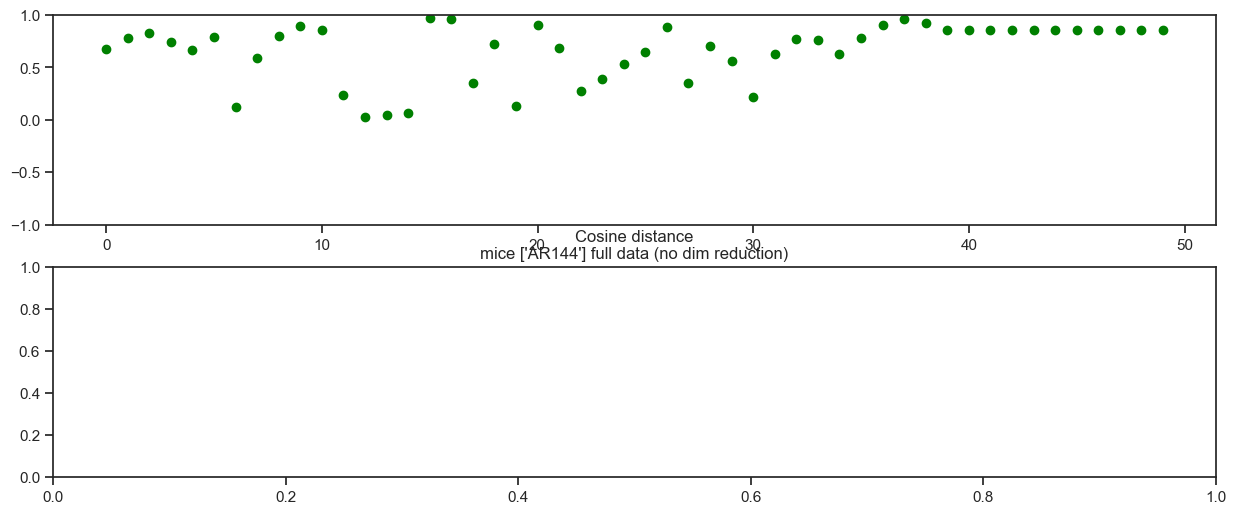

In [119]:
sampling_rate = 30
win = (1, 1.5)  # from stimulus onset to 300 ms after.
win = (int(win[0] * sampling_rate), int(win[1] * sampling_rate))
baseline = (0, 1)
baseline = (int(baseline[0] * sampling_rate), int(baseline[1] * sampling_rate))
n_trials = 50
days = ['-2', '-1', '0', '+1', '+2']
apply_pca = False
variance_to_retain = 0.8

mouse_list = ['AR144']

session_list, nwb_files = io.select_sessions_from_db(
    db_path, nwb_dir,
    experimenters=['AR', 'GF', 'MI'],
    exclude_cols=['exclude', 'two_p_exclude'],
    subject_id=mouse_list,
    day=['-2', '-1', '0', '+1', '+2'],
    two_p_imaging='yes')

act_map = imaging_utils.shape_features_matrix(mouse_list, session_list, processed_dir, 'UM', n_trials)
# Subtract baselines.
act_map = act_map - np.nanmean(act_map[:, :, baseline[0]:baseline[1]],
                               axis=2, keepdims=True)
act_learning = imaging_utils.shape_features_matrix(mouse_list, session_list, processed_dir, 'WH', n_trials)
# Subtract baselines.
act_learning = act_learning - np.nanmean(act_learning[:, :, baseline[0]:baseline[1]],
                               axis=2, keepdims=True)

# Add session dimension.
act_map = act_map.reshape(act_map.shape[0], int(act_map.shape[1]/n_trials), n_trials, -1)
act_learning = act_learning.reshape(act_learning.shape[0], int(act_learning.shape[1]/n_trials), n_trials, -1)


# TODO: dim reduction must be applied to all data Um and WH at the same time.
    
# Reduce dimensionality of the data.
if apply_pca:
    X = shape_feature_matrix(np.concatenate((act_learning, act_map), axis=1), win, fitting_type='single_bin')
    # Perform PCA.
    pca = PCA(n_components=None)
    model = pca.fit(X)
    act_map = apply_pca_model(act_map, model, 5, n_trials)
    act_map = act_map[pc_to_retain(model, variance_to_retain)]
    act_learning = apply_pca_model(act_learning, model, act_learning.shape[1], n_trials)
    act_learning = act_learning[pc_to_retain(model, variance_to_retain)]
print(act_learning.shape)
print(act_map.shape)

vect_naive = np.mean(act_map[:, 1, :, win[0]:win[1]], axis=(1,2))
pop_vect_learning = np.mean(act_learning[:, :, :, win[0]:win[1]], axis=(3))

cosine_dist_learning = np.zeros((pop_vect_learning.shape[1], n_trials))

def cosine_distance(a, b):
    return 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

for i in range(pop_vect_learning.shape[1]):
    for k in range(n_trials):
        cosine_dist_learning[i, k] = cosine_distance(pop_vect_learning[:, i, k],
                                                      vect_naive)


# Plot distance between naive vector and D0 responses.

sns.set_theme(context='notebook', style='ticks', palette='deep')
palette = sns.color_palette()
f, axes = plt.subplots(2, 1, figsize=(15, 6))

color = 'green'
axes[0].scatter(range(n_trials),
            cosine_dist_learning[0,:],
            color=color)
axes[0].set_ylim(-1, 1)
if apply_pca:
    plt.title('Cosine distance\n' \
              f'mice {mouse_list} ' \
              f'variance retained: {variance_to_retain}')
else:   
    plt.title('Cosine distance\n' \
              f'mice {mouse_list} ' \
              'full data (no dim reduction)')

# Add behavior of D0 below.
f = nwb_files[2]
session = session_list[2]
behav_table = nwb_read.get_trial_table(f)
behav_table = compute_performance(behav_table, session, db_path)

# Cut the session to the number of WH trials used.
# TODO implement cut session in behavior script to cut mapping trials.
n_WH = behav_table[(behav_table['whisker_stim'] == 1) & (behav_table['lick_flag'] == 1)].shape[0]
if n_WH <= n_trials:
    # If less than n_trials WH, then cut at the last one.
    cut = behav_table[(behav_table['whisker_stim'] == 1) & (behav_table['lick_flag'] == 1)].iloc[-1].name
    behav_table = behav_table.iloc[:cut+1]
else:
    # else cut at n_trials.
    cut = behav_table[(behav_table['whisker_stim'] == 1) & (behav_table['lick_flag'] == 1)].iloc[n_trials-1].name
    behav_table = behav_table.iloc[:cut+1]

palette = sns.color_palette()
plot_single_session(behav_table, session, axes[1])
plt.show()


### 3. Projection on the learning dimension.

Does it makes sense to look at that? I should see the same that with similarity but in that case signal amplitude may count (not with cosine similarity).

Other dimension obtained by substracting pop vectors of specific trial types could be interesting.
To remove the sensory component for example, or movement. 

(111, 50)

## UMAP and t-sne during learning


In [ ]:
sampling_rate = 30
win = (1, 1.5)  # from stimulus onset to 300 ms after.
win = (int(win[0] * sampling_rate), int(win[1] * sampling_rate))
baseline = (0, 1)
baseline = (int(baseline[0] * sampling_rate), int(baseline[1] * sampling_rate))
n_trials = 50
days = ['-2', '-1', '0', '+1', '+2']
apply_pca = True
variance_to_retain = 0.5

# AR132 has no WH trials.

mouse_list_rew = ['AR127', 'AR133', 'AR135', 'AR143', 'AR144',]
mouse_list_non_rew = ['AR131', 'AR132', 'AR137', 'AR139']
mouse_list_non_rew.pop(1)

for mouse in mouse_list_rew+mouse_list_non_rew:
    mouse_list = [mouse]
    session_list, nwb_files = io.select_sessions_from_db(
        db_path, nwb_dir,
        experimenters=['AR', 'GF', 'MI'],
        exclude_cols=['exclude', 'two_p_exclude'],
        subject_id=mouse_list,
        day=['-2', '-1', '0', '+1', '+2'],
        two_p_imaging='yes')

    act_map = imaging_utils.shape_features_matrix(mouse_list, session_list, processed_dir, 'UM', n_trials)
    # Subtract baselines.
    act_map = act_map - np.nanmean(act_map[:, :, baseline[0]:baseline[1]],
                                axis=2, keepdims=True)
    act_learning = imaging_utils.shape_features_matrix(mouse_list, session_list, processed_dir, 'WH', n_trials)
    # Subtract baselines.
    act_learning = act_learning - np.nanmean(act_learning[:, :, baseline[0]:baseline[1]],
                                axis=2, keepdims=True)

    # Add session dimension.
    act_map = act_map.reshape(act_map.shape[0], int(act_map.shape[1]/n_trials), n_trials, -1)
    act_learning = act_learning.reshape(act_learning.shape[0], int(act_learning.shape[1]/n_trials), n_trials, -1)

    # Reduce dimensionality of the data.
    if apply_pca:
        X = shape_feature_matrix(np.concatenate((act_learning, act_map), axis=1), win, fitting_type='single_bin')    
        # Perform PCA.
        pca = PCA(n_components=None)
        model = pca.fit(X)
        
        act_map = apply_pca_model(act_map, model, 5, n_trials)
        act_map = act_map[pc_to_retain(model, variance_to_retain)]
        act_learning = apply_pca_model(act_learning, model, act_learning.shape[1], n_trials)
        act_learning = act_learning[pc_to_retain(model, variance_to_retain)]

    X = shape_feature_matrix(act_learning, win, fitting_type='single_bin', zscore=True)
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(X)

    palettes = (sns.color_palette('Reds', n_colors=n_trials),
                sns.color_palette("Greens", n_colors=n_trials),
                sns.color_palette("Blues", n_colors=n_trials))

    plt.figure()
    for iday in range(3):
        d = embedding[iday*n_trials:(iday+1)*n_trials, :]
        palette = palettes[iday]
        for itrial in range(n_trials):
            plt.scatter(
                d[itrial, 0],
                d[itrial, 1],
                color=palette[itrial]
            )
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'{mouse_list} WH UMAP')
    plt.show()